In [11]:
# --- NOTEBOOK 03: MANIFOLD CARTOGRAPHY ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap  # pip install umap-learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Config
class Config:
    INPUT_PATH = 'clean_train.parquet'
    SEED = 42
    SUBSAMPLE = 50000  # UMAP gets slow > 50k
    
    # Drop features we know are bad (from NB 02)
    DROP_COLS = [
    # 1. The Zero-Variance / Redundant Flags
    'FLAG_MOBIL',           # VIF 17,000 (Constant)
    'FLAG_EMP_PHONE',       # VIF 2,372 (Redundant with Pensioner Flag)
    'FLAG_DOCUMENT_3',      # Redundant with ID_PUBLISH
    'REGION_RATING_CLIENT_W_CITY', # Redundant with REGION_RATING_CLIENT

    # 2. The Social Circle Echo (Keep 30, Drop 60)
    'OBS_60_CNT_SOCIAL_CIRCLE', 

    # 3. The Financial Echo (Keep Credit, Drop Goods)
    'AMT_GOODS_PRICE',
    
    # 4. The Housing Triplets (Keep AVG, Drop MEDI & MODE)
    'APARTMENTS_MEDI', 'APARTMENTS_MODE',
    'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
    'COMMONAREA_MEDI', 'COMMONAREA_MODE',
    'ELEVATORS_MEDI', 'ELEVATORS_MODE',
    'ENTRANCES_MEDI', 'ENTRANCES_MODE',
    'FLOORSMAX_MEDI', 'FLOORSMAX_MODE',
    'FLOORSMIN_MEDI', 'FLOORSMIN_MODE',
    'LANDAREA_MEDI', 'LANDAREA_MODE',
    'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE',
    'LIVINGAREA_MEDI', 'LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE'
]

print("Notebook 03 Initialized.")

Notebook 03 Initialized.


In [12]:
# !pip install umap-learn

In [13]:
def load_and_prep_manifold():
    # 1. Load & Sample
    df = pd.read_parquet(Config.INPUT_PATH)
    
    # Drop known noise
    df = df.drop(columns=[c for c in Config.DROP_COLS if c in df.columns])
    
    # Stratified Subsample
    from sklearn.model_selection import train_test_split
    X = df.drop(columns=['TARGET'])
    y = df['TARGET']
    
    # We need a small, representative chunk
    X_sub, _, y_sub, _ = train_test_split(
        X, y, train_size=Config.SUBSAMPLE, stratify=y, random_state=Config.SEED
    )
    
    # 2. Select Numeric Only (Manifold learning on One-Hot is messy)
    X_num = X_sub.select_dtypes(include=['number'])
    
    # 3. Strict Preprocessing
    # Impute Median -> Force Normal Distribution
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', QuantileTransformer(output_distribution='normal', random_state=Config.SEED))
    ])
    
    X_scaled = pipeline.fit_transform(X_num)
    
    print(f"Data Shape for Manifold: {X_scaled.shape}")
    return X_scaled, y_sub

X_viz, y_viz = load_and_prep_manifold()

Data Shape for Manifold: (50000, 72)


--- RUNNING PCA ---
Explained Variance (Top 3 Components): 34.42%


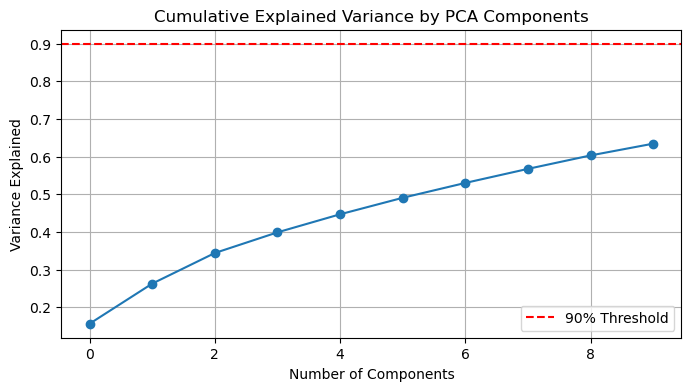

In [14]:
def run_pca_diagnostic(X):
    print("--- RUNNING PCA ---")
    pca = PCA(n_components=10) # Look at top 10 dimensions
    X_pca = pca.fit_transform(X)
    
    # Explained Variance
    evr = pca.explained_variance_ratio_
    print(f"Explained Variance (Top 3 Components): {np.sum(evr[:3]):.2%}")
    
    # Plot the "Elbow"
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(evr), marker='o')
    plt.axhline(0.90, color='r', linestyle='--', label='90% Threshold')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return X_pca

X_pca = run_pca_diagnostic(X_viz)

--- RUNNING UMAP (This may take 1-2 mins) ---


C:\Users\gopala.v.lv\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


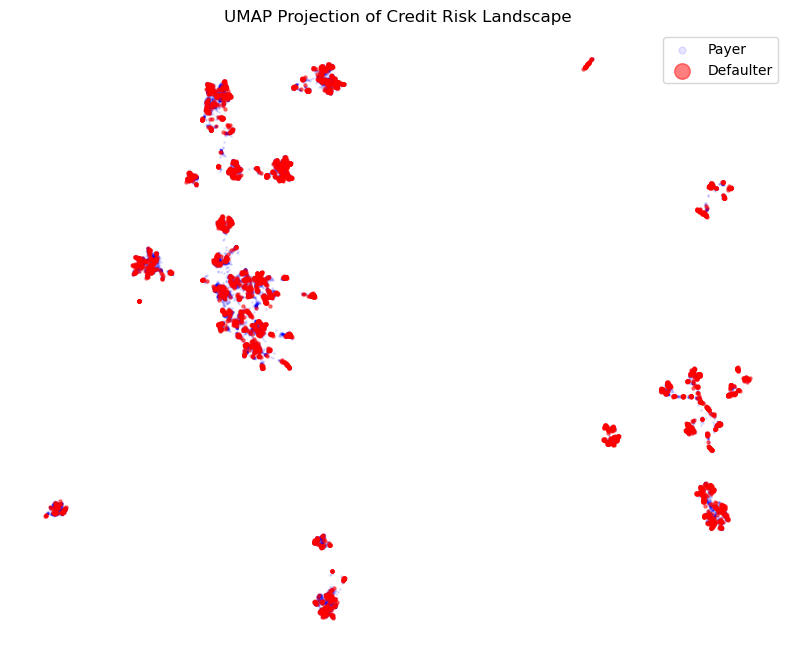

In [15]:
def run_umap_diagnostic(X, y):
    print("--- RUNNING UMAP ---")
    
    # UMAP parameters for global structure
    reducer = umap.UMAP(
        n_neighbors=30,    # Higher = Focus on global structure
        min_dist=0.1,      # Lower = Tighter clusters
        metric='euclidean',
        random_state=Config.SEED
    )
    
    embedding = reducer.fit_transform(X)
    
    # Visualization
    plt.figure(figsize=(10, 8))
    
    # Plot Payers (Target=0) in Blue, Defaulters (Target=1) in Red
    # We use alpha (transparency) because points overlap heavily
    plt.scatter(embedding[y==0, 0], embedding[y==0, 1], c='blue', s=1, alpha=0.1, label='Payer')
    plt.scatter(embedding[y==1, 0], embedding[y==1, 1], c='red', s=5, alpha=0.5, label='Defaulter')
    
    plt.title('UMAP Projection of Credit Risk Landscape')
    plt.legend(markerscale=5) # Make legend dots bigger
    plt.axis('off') # Hide axis numbers (they are meaningless in UMAP)
    plt.show()

run_umap_diagnostic(X_viz, y_viz)

UMAP visualization confirmed the "Salt and Pepper" theory.

The Meaning: Defaulters and Payers are geometrically mixed. There is no simple "Line" that separates them.

The Consequence: A Linear Model (like our Logistic Regression in NB 02) has hit its mathematical limit (AUC 0.74). It cannot snake through the salt and pepper.

The Solution: We need Trees (XGBoost) which can handle this complexity.